**Please note that this practical requires training a lot of models, which may be time consuming (~2h)**

# Machine Learning - Practical 3 - Multiclass Logistic Regression, MLP and CNNs


Names: {Lars Kaesberg, Luca Francis, Matthias Mildenberger}
Summer Term 2023
Due Date: Tuesday, May 30, 2pm

In this practical we will implement multiclass classification with classic Logistic Regression, Multilayer Preceptron, and the convolutional neural network LeNet5 on image data. We will compare the performance of these models. You will work on the following:

 1. Imports and Hardware check
 2. Loading data and related transformations 
 3. Defining training helper functions and metrics 
 4. Logistic Regression 
 5. MLP
 6. CNN
 7. Comparison of results across models

We'll be storing all the losses and accuracies while training, and plotting everything in the end. Use `tqdm` to keep track of your training and validation losses and accuracies since we're only plotting them in the end.

In [1]:
import time
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms

torch.manual_seed(42) # Set manual seed
from fastprogress.fastprogress import force_console_behavior

master_bar, progress_bar = force_console_behavior()


In [2]:
# DO NOT CHANGE
use_cuda = True
use_cuda = False if not use_cuda else torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
torch.cuda.get_device_name(device) if use_cuda else 'cpu'
print('Using device', device)

Using device cpu


## Define data transformations

We will work with the CIFAR-10 dataset, an established computer vision dataset used for object recognition. It is a subset of the 80 million tiny images dataset and consists of 60,000 32x32 color images containing one of 10 object classes, with 6000 images per class. It was collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. The goal of this dataset is to predict the image class.

Note: The constants in `transforms.Normalize()` are the means and standard deviations of the three color channels of the images in the CIFAR-10 training set. You can verify these numbers yourself by re-computing them.

In [3]:
batch_size = 256

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

In [4]:
# Load the data and transform the dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transforms)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transforms)


Files already downloaded and verified
Files already downloaded and verified


In [5]:
# You can verify the mean and standard deviation used in the normalization above by calculating the mean and std of the training dataset above.
# TODO: make dataloaders (from torch.utils) from datasets, define batch size and do not forget shuffling
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=256)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=256)
 

In [39]:
## TODO: plot images with their labels after augmentations
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
def show_batch(dl):
    minmax_fn = lambda X: (X - X.min())/(X.max() - X.min())

    batch = next(iter(dl))
    fig, ax = plt.subplots(16, 16, figsize=(15, 15))
    for index, item in enumerate(batch[0]):
        item = item.permute(1, 2, 0)
        ax.flat[index].axis('off')
        ax.flat[index].imshow(minmax_fn(item))
        ax.flat[index].set_title(classes[batch[1][index]])
    fig.tight_layout()
    fig.subplots_adjust(wspace=0, hspace=0.5)

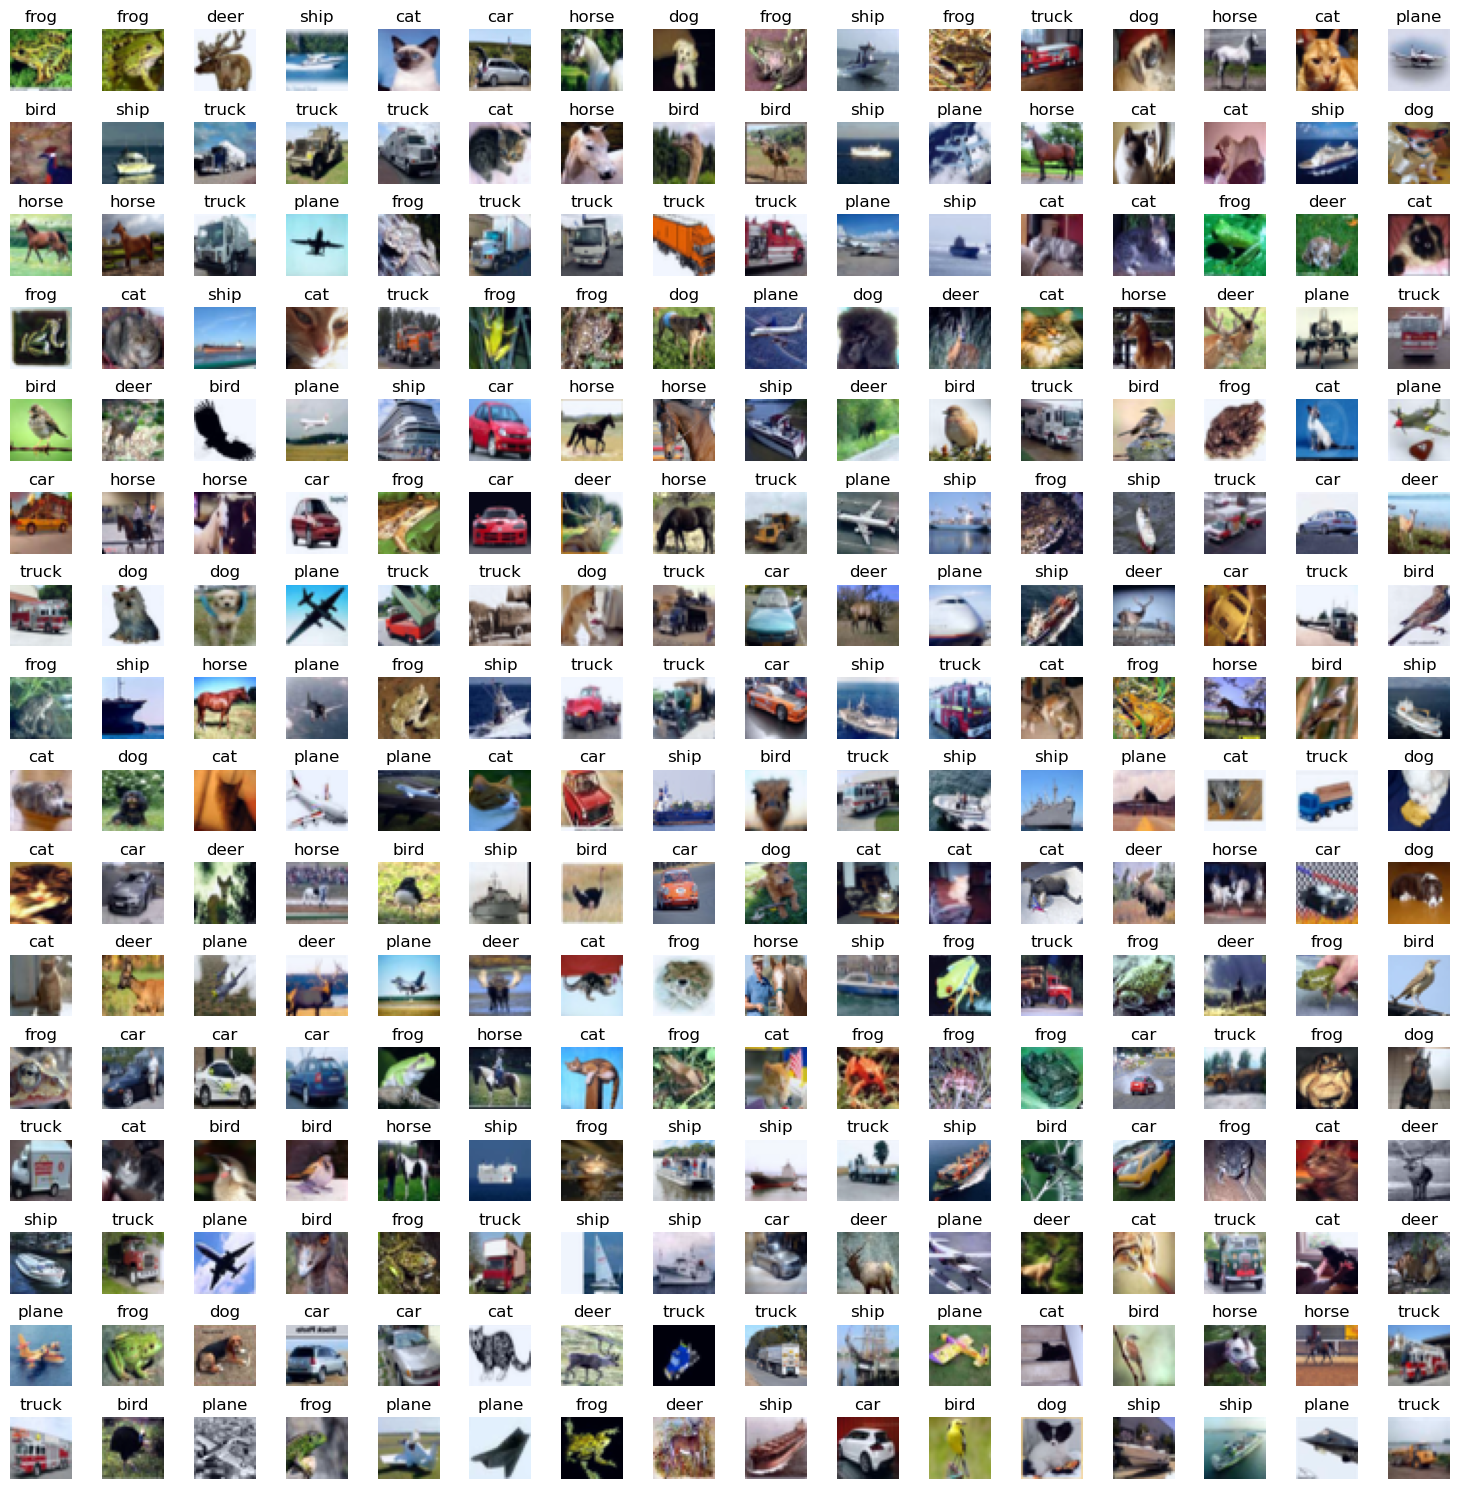

In [40]:
show_batch(train_loader)

In [7]:
num_classes = 10

## Define helper functions for training and metrics

You will need these again and again. 

In [8]:
## TODO: write a function that calculates the accuracy

def accuracy(correct, total): 
    """
    function to calculate the accuracy given the
        correct: number of correctly classified samples
        total: total number of samples
    returns the ratio
    """
    return float(correct)/total

In [9]:
def train(dataloader, optimizer, model, loss_fn, device, master_bar):
    """Run one training epoch.

    Args:
        dataloader (DataLoader): Torch DataLoader object to load data
        optimizer: Torch optimizer object
        model (nn.Module): Torch model to train
        loss_fn: Torch loss function
        device (torch.device): Torch device to use for training
        master_bar (fastprogress.master_bar): Will be iterated over for each
            epoch to draw batches and display training progress

    Returns:
        float, float: Mean loss of this epoch, fraction of correct predictions
            on training set (accuracy)
    """
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0

    for x, y in progress_bar(dataloader, parent=master_bar):
        optimizer.zero_grad()
        model.train()

        # Forward pass
        y_pred = model(x.to(device))

        # For calculating the accuracy, save the number of correctly classified
        # images and the total number
        epoch_correct += sum(y.to(device) == y_pred.argmax(dim=1))
        epoch_total += len(y)

        # Compute loss
        loss = loss_fn(y_pred, y.to(device))

        # Backward pass
        loss.backward()
        optimizer.step()

        # For plotting the train loss, save it for each sample
        epoch_loss.append(loss.item())

    # Return the mean loss and the accuracy of this epoch
    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total)


def validate(dataloader, model, loss_fn, device, master_bar):
    """Compute loss, accuracy and confusion matrix on validation set.

    Args:
        dataloader (DataLoader): Torch DataLoader object to load data
        model (nn.Module): Torch model to train
        loss_fn: Torch loss function
        device (torch.device): Torch device to use for training
        master_bar (fastprogress.master_bar): Will be iterated over to draw
            batches and show validation progress

    Returns:
        float, float, torch.Tensor shape (10,10): Mean loss on validation set,
            fraction of correct predictions on validation set (accuracy)
    """
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0
    confusion_matrix = torch.zeros(10, 10)

    model.eval()
    with torch.no_grad():
        for x, y in progress_bar(dataloader, parent=master_bar):
            # make a prediction on validation set
            y_pred = model(x.to(device))

            # For calculating the accuracy, save the number of correctly
            # classified images and the total number
            epoch_correct += sum(y.to(device) == y_pred.argmax(dim=1))
            epoch_total += len(y)

            # Fill confusion matrix
            for (y_true, y_p) in zip(y, y_pred.argmax(dim=1)):
                confusion_matrix[int(y_true), int(y_p)] += 1

            # Compute loss
            loss = loss_fn(y_pred, y.to(device))

            # For plotting the train loss, save it for each sample
            epoch_loss.append(loss.item())

    # Return the mean loss, the accuracy and the confusion matrix
    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total), confusion_matrix


def run_training(model, optimizer, loss_function, device, num_epochs,
                 train_dataloader, val_dataloader):
    """Run model training.

    Args:
        model (nn.Module): Torch model to train
        optimizer: Torch optimizer object
        loss_fn: Torch loss function for training
        device (torch.device): Torch device to use for training
        num_epochs (int): Max. number of epochs to train
        train_dataloader (DataLoader): Torch DataLoader object to load the
            training data
        val_dataloader (DataLoader): Torch DataLoader object to load the
            validation data

    Returns:
        list, list, list, list, torch.Tensor shape (10,10): Return list of train
            losses, validation losses, train accuracies, validation accuracies
            per epoch and the confusion matrix evaluated in the last epoch.
    """
    start_time = time.time()
    mb = master_bar(range(num_epochs))
    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in mb:
        # Train the model
        epoch_train_loss, epoch_train_acc = train(train_dataloader, optimizer, model,
                                                  loss_function, device, mb)
        # Validate the model
        epoch_val_loss, epoch_val_acc, confusion_matrix = validate(val_dataloader,
                                                                   model, loss_function,
                                                                   device, mb)

        # Save loss and acc for plotting
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accs.append(epoch_train_acc)
        val_accs.append(epoch_val_acc)

    time_elapsed = np.round(time.time() - start_time, 0).astype(int)
    print(f'Finished training after {time_elapsed} seconds.')
    return train_losses, val_losses, train_accs, val_accs, confusion_matrix

In [10]:
# TODO: write a function to calculate and return the confusion values
def calc_confusion_values(dataloader, model, device):
    """ method to compute the confusion values on the validation set """
    _, _, confusion_matrix = validate(dataloader, model, device, None)
    return confusion_matrix

## Logistic Regression   

In [12]:
class LR(torch.nn.Module):
    """
    Logistic regression model inherits from the torch.nn.Module 
    which is the base class for all neural network modules.
    """
    def __init__(self, input_dim, output_dim):
        """ Initializes internal Module state. """
        super(LR, self).__init__()
        # TODO: define linear layer for the model
        self.layer = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x: torch.Tensor):
        """ Defines the computation performed at every call. """
        # What are the dimensions of your input layer?
        # TODO: flatten the input to a suitable size for the initial layer
        x = x.flatten(start_dim=1)
        # TODO: run the data through the layer
        outputs = self.layer(x)
        return outputs

In [13]:
## TODO: Define network in the variable named 'linear_regression', put it to the device and train mode
linear_regression = LR(input_dim=32*32*3, output_dim=num_classes)
linear_regression = linear_regression.to(device)
linear_regression.train()


LR(
  (layer): Linear(in_features=3072, out_features=10, bias=True)
)

In [14]:
## Optimiser defined. We're going to use Adam since it's always the safe bet, and also for faster convergence. 
optimizer = torch.optim.Adam(linear_regression.parameters(), lr=0.001)

### Define loss 

Since we're dealing with multi-class classification (i.e. multiple categories), softmax is the canonical choice for the final layer activation. Softmax provides us with a distribution of values in \[0, 1\] that sum up to 1 over all categories.

We then use the cross entropy to compute the loss.

Hint: Due to numerical reasons, softmax and cross entropy are combined into one operation. Read more about it in https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html.

In [11]:
# TODO: define the loss function
loss = torch.nn.CrossEntropyLoss()

In [16]:
num_epochs = 20
## TODO: run training over 20 epochs
lr_train_losses, lr_val_losses, lr_train_accs, lr_val_accs, lr_confusion_matrix = run_training(linear_regression, optimizer, loss, device, num_epochs, train_loader, test_loader)

 Finished training after 279 seconds.


## Multilayer Perceptron

MLP is a network which consists of several linear fully-connected layers with non-linearities between them.

### Question:
Why are non-linearities between linear layers important?

In [17]:
class MLP(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(input_dim, 1650),
            torch.nn.ReLU(),
            nn.Linear(1650, 512),
            nn.ReLU(),
            nn.Linear(512,138),
            nn.ReLU(),
            nn.Linear(138, output_dim)
        )
        
        
    def forward(self, x):
        ## TODO: write the forward pass
        ## Do not forget to flatten the input

        return self.model(x)

In [18]:
## TODO: Define network, put it to device and train mode
multi = MLP(input_dim=32*32*3, output_dim=num_classes)
multi = multi.to(device)
multi.train()

MLP(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3072, out_features=1650, bias=True)
    (2): ReLU()
    (3): Linear(in_features=1650, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=138, bias=True)
    (6): ReLU()
    (7): Linear(in_features=138, out_features=10, bias=True)
  )
)

In [19]:
## TODO: Define optimizer and loss functions
optimizer = torch.optim.Adam(multi.parameters(), lr=0.001)


In [20]:
## TODO: Train the MLP over 20 epochs
mlp_train_losses, mlp_val_losses, mlp_train_accs, mlp_val_accs, mlp_confusion_matrix = run_training(multi, optimizer, loss, device, num_epochs, train_loader, test_loader)

 Finished training after 302 seconds.


## Add L2 regularisation

In [21]:
# TODO: Define new model, optimizer, put model to device, etc.
## 0.0005 is a good starting point for the regularization strength
multi = MLP(input_dim=32*32*3, output_dim=num_classes)
multi = multi.to(device)
multi.train()
optimizer = torch.optim.Adam(multi.parameters(), lr=0.001, weight_decay=0.0005)

In [22]:
## TODO: Retrain new model with regularization over 20 epochs
l2_mlp_train_losses, l2_mlp_val_losses, l2_mlp_train_accs, l2_mlp_val_accs, l2_mlp_confusion_matrix = run_training(multi, optimizer, loss, device, num_epochs, train_loader, test_loader)

 Finished training after 298 seconds.


## LeNet5

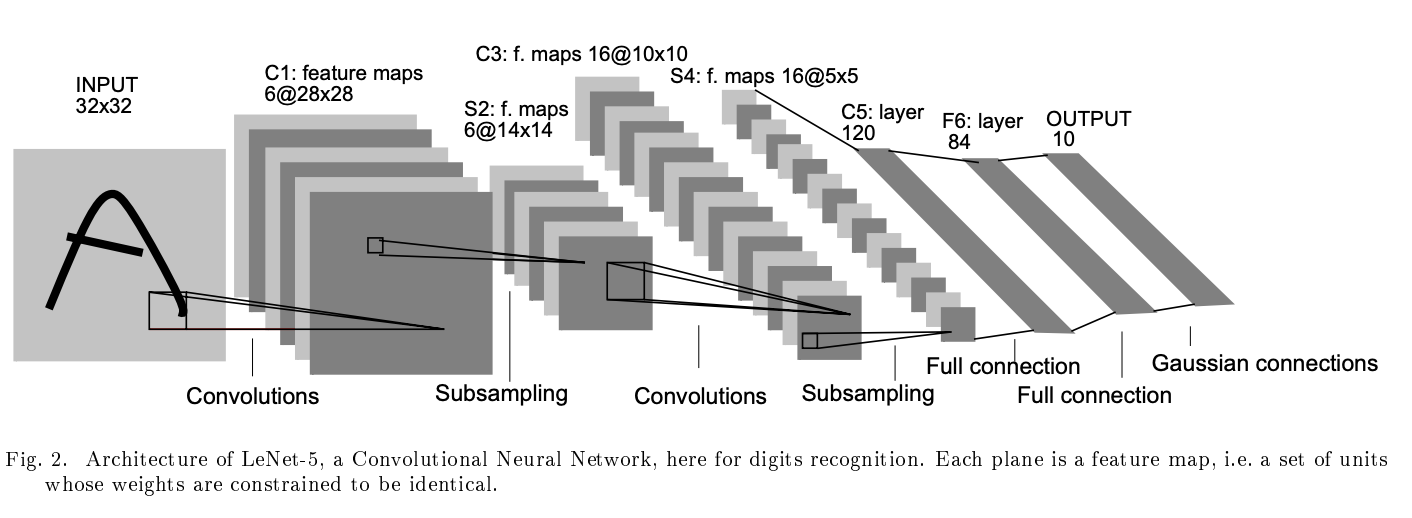

Let's implememt one of the classical convolutional network and apply it for CIFA10. Here is the link for the [original paper](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf) of LeNet5 introduced by Yann LeCun and colleagues in 1998. The original implentation of LeNet5 has Tanh as non-linearities. In 2012, AlexNet famously set off the deep learning revolution. AlexNet is based on LeNet, with two main innovations: (1) making it deeper by adding a few extra layers and (2) replacing the tanh activation functions by ReLU to improve training. Here we'll the original LeNet5 architecture to keep the compute requirements small, but work with the more modern ReLU activation functions.

One more thing we change in the original network is the number of input channels as LeNet5 was designed for grayscale MNIST dataset, where each picture has 1 channel, while for RGB pictures we have 3 channels in the input data.


In [12]:
class LeNet5(nn.Module):

    def __init__(self, n_classes, in_channels=1):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(6, 16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(16, 120, kernel_size=5, stride=1),
            nn.ReLU(),
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(84, n_classes)
        )



    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [13]:
## TODO: define network, put it to the device and train mode
cnn = LeNet5(num_classes, 3)
cnn = cnn.to(device)
cnn.train()

LeNet5(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (7): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): ReLU()
    (2): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [14]:
## TODO: define loss function and optimisers
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)

In [15]:
## TODO: train with 20 epochs
num_epochs = 20
cnn_train_losses, cnn_val_losses, cnn_train_accs, cnn_val_accs, cnn_confusion_matrix = run_training(cnn, optimizer, loss, device, num_epochs, train_loader, test_loader)

Finished training after 294 seconds.                                                  


## Analysis 

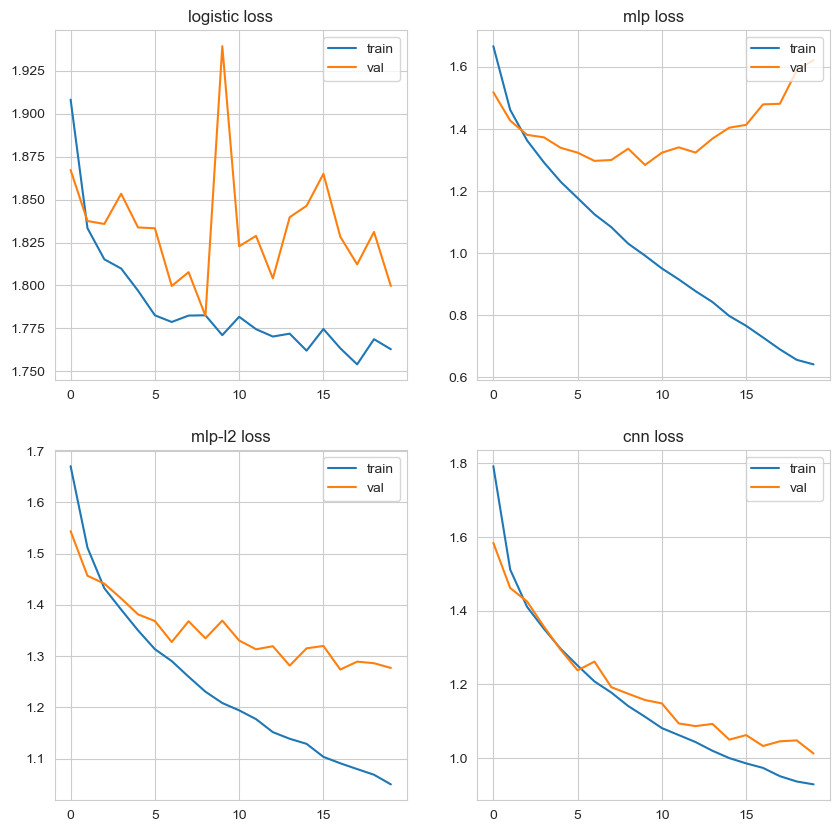

In [59]:
## TODO: Plot both train and val losses for all models.
names = ["logistic", "mlp", "mlp-l2", "cnn"]
train_losses = [lr_train_losses, mlp_train_losses, l2_mlp_train_losses, cnn_train_losses]
val_losses = [lr_val_losses, mlp_val_losses, l2_mlp_val_losses, cnn_val_losses]

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for index, (train_loss, val_loss) in enumerate(zip(train_losses, val_losses)):
    ax.flat[index].plot(train_loss, label = "train")
    ax.flat[index].plot(val_loss, label = "val")
    ax.flat[index].set_title(names[index] + " loss")
    ax.flat[index].legend(loc="upper right")
## What do you see?

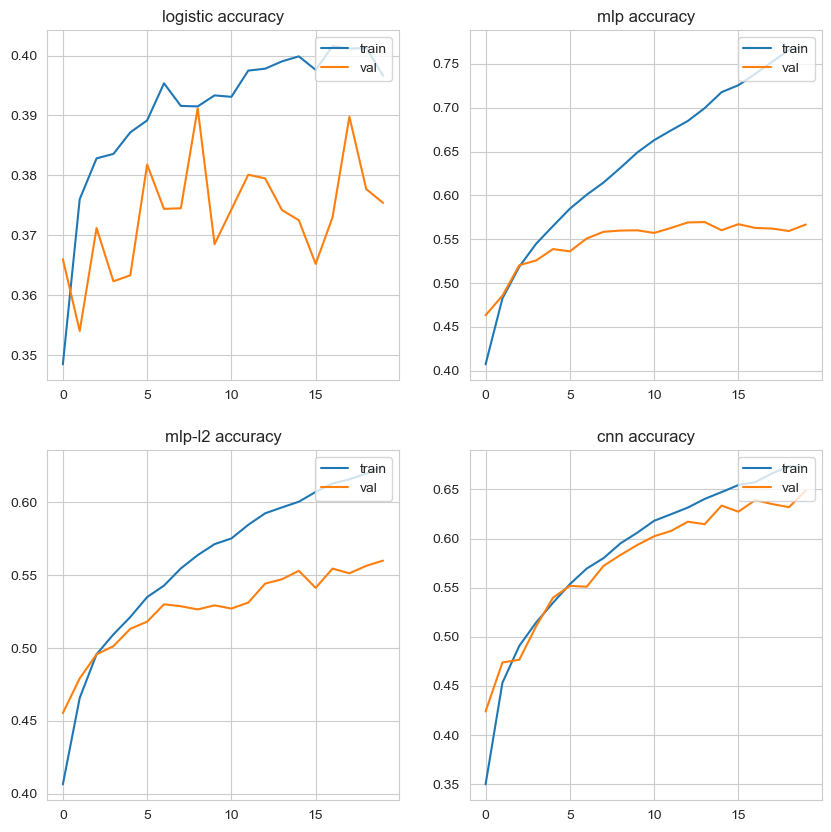

In [60]:
## TODO: Plot both train and val accuracies for all models.

train_accs = [lr_train_accs, mlp_train_accs, l2_mlp_train_accs, cnn_train_accs]
val_accs = [lr_val_accs, mlp_val_accs, l2_mlp_val_accs, cnn_val_accs]

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for index, (train_acc, val_acc) in enumerate(zip(train_accs, val_accs)):
    ax.flat[index].plot(train_acc, label = "train")
    ax.flat[index].plot(val_acc, label = "val")
    ax.flat[index].set_title(names[index] + " accuracy")
    ax.flat[index].legend(loc="upper right")
## What do you see?

In [19]:
cnn_confusion_matrix.shape

torch.Size([10, 10])

Text(0.5, 1.0, 'Confusion Matrix')

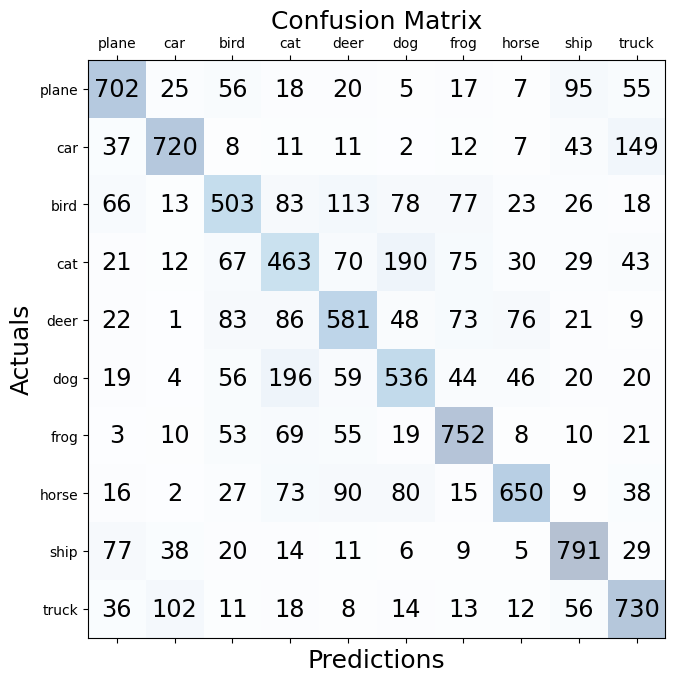

In [22]:
## TODO: Plot the confusion matrix for LeNet5
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(cnn_confusion_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cnn_confusion_matrix.shape[0]):
    for j in range(cnn_confusion_matrix.shape[1]):
        ax.text(x=j, y=i,s=int(cnn_confusion_matrix[i, j].item()), va='center', ha='center', size='xx-large')

ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)

## Questions
* How did regularization change the performance of the MLP? Why?
    * It decreased the accuracy on the training set. It didn't yet increase accuracy on the val set also. But it looks like the curve for the non regularized val-accuracy is already converged, while the regularized one still has some room for improvement. This is due to the reasons of regularization, that's supposed to decrease the risk of overfitting and making the model generalize better. 
* Explain the confusion matrix for LeNet5. What do you see there?
    * In general, it performs quite well. There's some classes, that are getting confused with each other more ofthen than others. For exmaples dogs get confused with cats, horses with deers and cars with trucks. This is understandable, since those classes do share some features (four legs or tires for example).
* Explain the difference in peformance between logistic regression, MLP, and LeNet5.
    * It keeps on getting better. The model of the logistic regression is apparently not big enough to explain the data enough. The MLP itself has a big enough model to even overfit on the model (with regularization this can be prevented). LeNet5 performs best on the data since they exploit certain properties of images. 
* Why are convolutions better suited for pictures? Which properties of images do they exploit?
    * Local Connectivity (pixels close to each other will be convoluted together)
    * Parameter sharing (allows for a bigger model)
    * Hierarchical Representation (With each layer, more abstract features can be represented)
    * Invariance to local transformations (Convolutions are invariant to local translations in the image, thus learned features can be 'reused' across the whole image)
* Is it important to redefine an optimizer for each different model, training? What about loss functions?
    * Optimizer should be different, since it stores the gradients for the parameters. The loss function can be reused since it doesn't contain any state.

## Additional experiments (Optional)
* Try to replace CIFAR10 dataset with MNIST. What do you notice? Why? Try to explain the differences in terms of variance or dataset complexity
